So somehow recursive prediction is not working properly. We can do two tests: first just raining a very long training reservoir, training on the initial stuff. Another one is just driving the reservoior and calculating vv.

In [1]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from recurrent_kernel import recurrent_kernel, erf_kernel, weighted_dot, update_fn, diagonal_update_fn
from jax.lax import scan

%config InlineBackend.figure_format = 'svg'

In [2]:
# Data
data_train = jnp.load('u_train.npy')
data_test = jnp.load('u_test.npy')
data_full = jnp.concatenate([data_train, data_test])

# These are the baselines from explicit reservoirs
K_baseline_train = jnp.load('K_baseline_train.npy')
K_baseline_test = jnp.load('K_baseline_test.npy')
K_baseline_full = jnp.concatenate([K_baseline_train, K_baseline_test], axis=0)

# This is the explicit reservoir run over all data
K_true = jnp.load('K_true.npy')

In [3]:
scaling = (0.4, 0.9, 0.4)
renorm = 0.11
N_train = 10000
N_init = 50

# Test 1 - all data

As a first data and baseline we run the kernel over the whole dataset, if correct it should approach the explicit reservoir.

In [4]:
K_full = recurrent_kernel(data_full, erf_kernel, scaling)

In [5]:
# First row and column should be zero
print(jnp.sum(K_full[:, 0]) == 0)
print(jnp.sum(K_full[0, :]) == 0)

True
True


Okay let's see what's the diff:

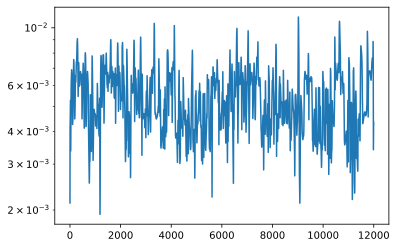

In [6]:
# Remove zero column and row 
plt.semilogy(jnp.mean(jnp.abs(K_full[1:, 1:] - K_true[1:, 1:]), axis=1))

That looks reasonable. Let's plot it to be sure:

(3000.0, 5000.0)

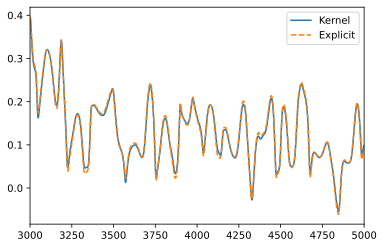

In [7]:
idx = 3000
plt.plot(K_full[:, idx], label='Kernel')
plt.plot(K_true[:, idx], '--', label='Explicit')

plt.legend()
plt.xlim([3000, 5000])

Okay that seems to work. Let's train an output layer based on this:

In [8]:
K_train = (K_full + renorm * jnp.dot(data_full, data_full.T))[N_init:N_train, N_init:N_train]

alpha =1e-2 # cant go below 1e-4, thats reasonable
K_train = jax.ops.index_add(K_train, jnp.diag_indices(K_train.shape[0]), alpha)
c, low = jax.scipy.linalg.cho_factor(K_train, check_finite=False)
W_out = jax.scipy.linalg.cho_solve((c, low), data_full[N_init:N_train], check_finite=False)

Okay lets predict with this:

In [9]:
K_predict = (K_full + renorm * jnp.dot(data_full, data_full.T))[:, N_init:N_train]
prediction = jnp.dot(K_predict, W_out)

okay lets look at the difference:

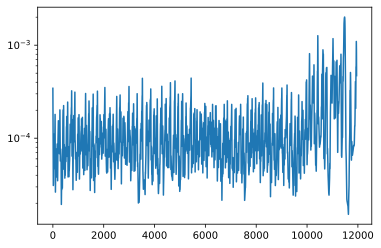

In [10]:
plt.semilogy(jnp.mean(jnp.abs(data_full[N_init:] - prediction[N_init:]), axis=1))

So it increases a little bit in prediction overall pretty good. Let's look at the prediction:

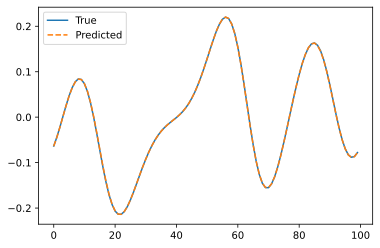

In [11]:
frame = 11000

plt.plot(data_full[frame], label='True')
plt.plot(prediction[frame], '--', label='Predicted')

plt.legend()

So this works. If we cut the the data and use a training and test procedure and still drive the test procedure by the real data we should have exactly the same. Let's call this K_goal:

In [12]:
K_goal = recurrent_kernel(data_full, erf_kernel, scaling)

# Test 2 - Splitting into train / test

If we split the data into test/train and run the reservoir with the real data, we should get exactly the same kernel.

In [13]:
# first lets check K_train
K_train = recurrent_kernel(data_train, erf_kernel, scaling)
print(jnp.allclose(K_goal[:N_train, :N_train], K_train))

True


Thats expected - the fun is in the prediction. For the prediction, we need:

* The correct gram matrix
* Diagonal <u, u>
* the initial <v, v>

Lets start with the gram matrix:

In [14]:
# initial element should be last element of train gram
# We run up until the last element of the test data
# We dont need the last element of train 
gram_predict_ini = jnp.dot(data_train[[-1]], data_train[:-1].T)
gram_predict_test = jnp.dot(data_test[:-1], data_train[:-1].T)

gram_predict = jnp.concatenate([gram_predict_ini, gram_predict_test], axis=0)

In [15]:
# gram should be N_test x N_train -1
# N_test because (N_test -1) steps from N_test, +1 from last of train
# and N_train -1 because we neglect the first column of zeros
gram_predict.shape

(2000, 9999)

Now the diagonal <u, u>:

In [16]:
gram = jnp.dot(data_train, data_train.T)
dot_fn = weighted_dot(*scaling)

# We need all elements up until the last
uu = dot_fn(jnp.diag(gram)[:-1], jnp.diag(K_train)[:-1])

In [17]:
uu.shape

(9999,)

Now we do <v, v>

In [18]:
K_diag_predict = jnp.diag(K_full)[(N_train -1): -1]
gram_diag_predict = jnp.concatenate([gram[-1, [-1]], jnp.diag(jnp.dot(data_test[:-1], data_test[:-1].T))])
vv = dot_fn(gram_diag_predict, K_diag_predict)

# First of <v,v> predict K should be last of K_train
print(K_train[-1, -1] == K_diag_predict[0])
print(vv.shape)

True
(2000,)


Now we need to construct the initial K - we cut off the zeros:

In [19]:
K_predict_ini = K_train[-1, 1:]

In [20]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev = carry
        gram_prev, vv = inputs
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        return k, k
    return predict

In [21]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)

In [22]:
%%time
_, K_test = jax.lax.scan(rec_pred_fn, K_predict_ini, (gram_predict, vv))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 204 ms


Okay drumrolls:

In [23]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))
print(jnp.max(jnp.abs(K_full[N_train:, :N_train] - K_test)))

True
2.682209e-07


YEAAAAAHHHHHHH.

So as a final check - lets concatenate them and see the difference:

In [24]:
K_full_concat = jnp.concatenate([K_train, K_test], axis=0)

In [25]:
K_full_concat.shape

(12000, 10000)

In [27]:
jnp.allclose(K_full_concat, K_full[:, :N_train], atol=1e-7)

DeviceArray(True, dtype=bool)

Great :-) Now let's collect it:

In [30]:
K_train = recurrent_kernel(data_train, erf_kernel, scaling)
K_predict_ini = K_train[-1, 1:]

# Gram to iterate over
gram_predict_ini = jnp.dot(data_train[[-1]], data_train[:-1].T)
gram_predict_test = jnp.dot(data_test[:-1], data_train[:-1].T)
gram_predict = jnp.concatenate([gram_predict_ini, gram_predict_test], axis=0)

# Getting back uu
gram = jnp.dot(data_train, data_train.T)
dot_fn = weighted_dot(*scaling)
uu = dot_fn(jnp.diag(gram)[:-1], jnp.diag(K_train)[:-1])

# Calculating vv
K_diag_predict = jnp.diag(K_full)[(N_train -1): -1]
gram_diag_predict = jnp.concatenate([gram[-1, [-1]], jnp.diag(jnp.dot(data_test[:-1], data_test[:-1].T))])
vv = dot_fn(gram_diag_predict, K_diag_predict)

In [33]:
def predict_fn(kernel_fn, dot_fn, uu):
    def predict(carry, inputs):
        k_prev = carry
        gram_prev, vv = inputs
        
        # Updating kernel
        k_prev = jnp.pad(k_prev[:-1], (1, 0))
        uv = dot_fn(gram_prev, k_prev)
        k = kernel_fn(uv, uu, vv)
        
        return k, k
    return predict

In [34]:
rec_pred_fn = predict_fn(erf_kernel, dot_fn, uu)
_, K_test = jax.lax.scan(rec_pred_fn, K_predict_ini, (gram_predict, vv))
K_test = jnp.pad(K_test, ((0, 0), (1, 0))) # Need to add in the zeros

In [35]:
print(jnp.allclose(K_full[N_train:, :N_train], K_test, atol=1e-7))

True


In [ ]:
@partial(jit, static_argnums=(1,))
def recurrent_kernel(
    data: jnp.ndarray, kernel_fn: Callable, scaling_args: Tuple[float, float, float]
) -> jnp.ndarray:
    # Preliminaries
    dot_fn = weighted_dot(*scaling_args)
    gram = jnp.dot(data[:-1], data[:-1].T)
    n_samples = gram.shape[0]

    # Getting diagonal results and <u, u>
    _, k_diagonal = scan(
        diagonal_update_fn(kernel_fn, dot_fn),
        0.0,
        jnp.diag(gram),
    )
    k_diagonal = jnp.pad(k_diagonal[:-1], (1, 0))
    uu = dot_fn(jnp.diag(gram), k_diagonal)

    # Running over axes
    _, K_recurrent = scan(
        update_fn(kernel_fn, dot_fn, uu),
        jnp.zeros((n_samples,)),
        (gram, uu),
    )
    # Padding with zeros for first data.
    return jnp.pad(K_recurrent, ((1, 0), (1, 0)))
